---
title: Implementing the Perceptron Algorithm
author: Evan Flaks
date: '2025-03-23'
image: "perceptron.jpeg"
description: "Implementating the perceptron algorithm and testing it in several experiments."
format: html
---

# Abstract

In this project, I implement the perceptron algorithm from scratch using PyTorch to explore how linear classifiers work in both two-dimensional and higher-dimensional spaces. The perceptron is one of the earliest and most foundational machine learning algorithms, and this blog post walks through its logic, gradient updates, and training behavior. I apply the perceptron to synthetic datasets to examine its performance on linearly separable versus non-linearly separable data, and I visualize how the decision boundary and loss evolve over time. The goal is to gain an intuitive and practical understanding of how the perceptron learns from data and where its limitations lie.

# My Perceptron Implementation

This project uses the [perceptron.py](perceptron.py)
 script. The LinearModel class defines the basic structure, including methods to initialize the weight vector w, compute linear scores for input data (score), and make binary predictions (predict). The Perceptron class inherits from LinearModel and adds a loss method that calculates the misclassification rate. Finally, the PerceptronOptimizer class defines a step method that updates the model’s weights by applying the perceptron rule to a single data point. 

The grad() function computes the update for the perceptron algorithm. The perceptron algorithm updates the weights only when a data point is misclassified. A point is misclassified when:
$$\langle \textbf{w},\textbf{x}_i \rangle \cdot y_i < 0$$
In the grad function, I convert the labels of $\{0,1\}$ to $\{-1,1\}$ by using 
$$y' = 2y-1$$
Then, it computes the score $s = \langle \textbf{w},\textbf{x}_i \rangle$, and if $s \cdot y' < 0$, the point is misclassified. In that case, we return the update 
$$-y' \cdot \textbf{x}_i$$
This pushes the weights in a direction that would correctly classify the point. If the point is already classified correctly, no update is needed, and the function returns a zero vector.

In [26]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer, LinearModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The code above re-reads the contents of the [perceptron.py](perceptron.py) file, so that changes made in that file will be reflected in this notebook.

# Creating and Visualizing Sample Data Points

The code below generates and visualizes synthetic 2D data for training a perceptron model. It uses PyTorch to create n_points (default 300) split into two classes, with half labeled as 0 and the other half as 1. Each data point is generated by adding Gaussian noise to the class label, creating two slightly overlapping clusters in a 2D space. An additional bias term (column of ones) is added to the feature matrix X. The plot_perceptron_data function then visualizes the data using Matplotlib, plotting class 0 and class 1 points with different markers and slight color variations.

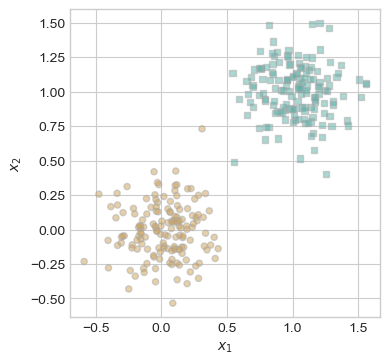

In [9]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    
    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

# Testing My Perceptron Algorithm

Now that we have implemented our perceptron algorithm and have some simple data to work with, it's time to check our implementation by running this "minimal training loop" below.

In [15]:
from perceptron import Perceptron, PerceptronOptimizer
import torch
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

We can track the progress of our training by checking the values of the loss function over time:

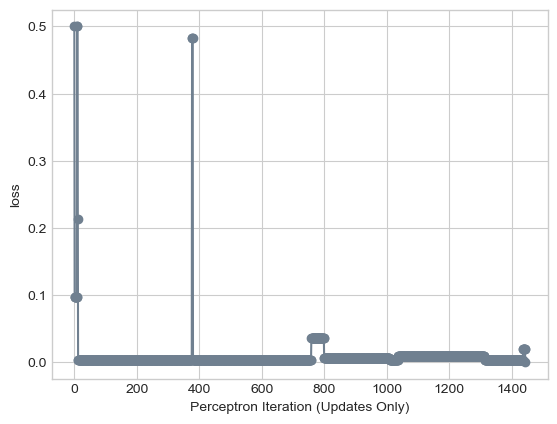

In [16]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

As we can see, over the course of the iterations, the loss value (y-axis) goes to 0, which indicates perfect training accuracy.

# Experiments

### Evolution of Loss Function During Training: Linearly Separable Data

Using 2D data that is linearly separable, the perceptron algorithm converges to weight vector $\vec{w}$, describing a separating line.

The code below repeatedly performs perceptron updates on randomly selected misclassified points from the dataset until the model achieves zero classification error. For each update, it plots the old decision boundary (before the weight update) as a dashed line and the new decision boundary (after the update) as a solid line on a subplot. The misclassified point used for the update is also highlighted. These plots are arranged in a 2x3 grid, showing the evolution of the model's decision boundary over successive updates. This gives a clear visual demonstration of how the perceptron learns to separate the data through linear updates. Citation: this code was provided from these [lecture notes](https://www.philchodrow.prof/ml-notes/chapters/20-perceptron.html#fig-demonstration).

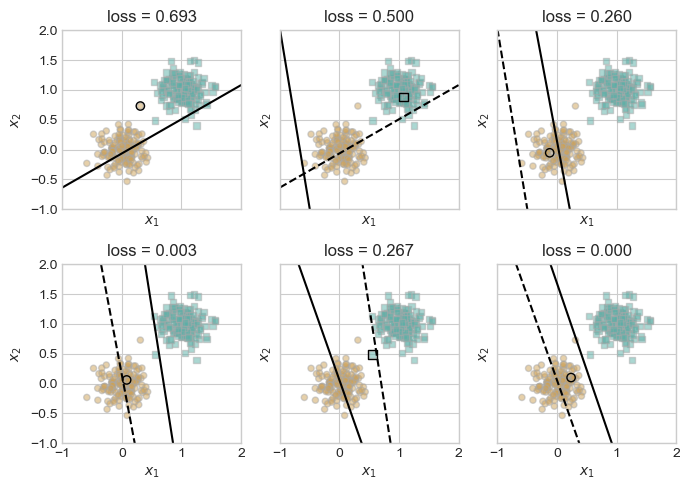

In [19]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        opt.step(x_i, y_i)
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

### Non-Linearly Separable Data

Now for 2D data that is not linearly separable, the perceptron algorithm will not settle on a final value of $\vec{w}$, but will instead run until the maximum number of iterations is reached, without achieving perfect accuracy.

The code below trains a perceptron on 2D data that is not linearly separable by adding significant noise to the dataset. It runs the training loop for a fixed number of iterations (1000), since the perceptron can't perfectly separate the classes in this case. At each step, it selects a random data point and updates the model weights if the point is misclassified. After training, it generates two plots: one showing the data and the final decision boundary, and another showing how the perceptron's misclassification rate (loss) evolved over time.

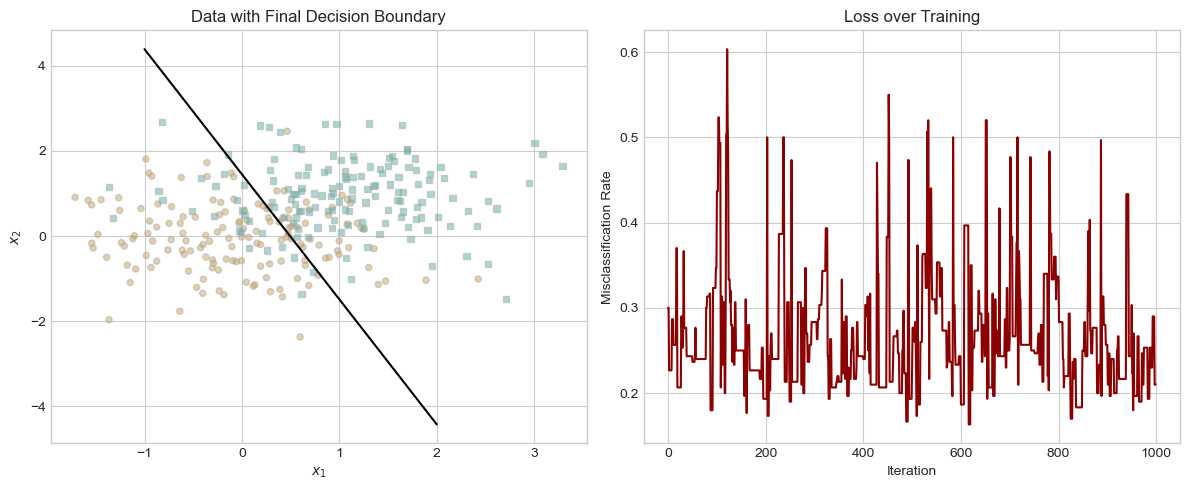

In [20]:
import torch
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# Helper: draw decision boundary line from weight vector
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    ax.plot(x, y, **kwargs)

# Generate NON-linearly separable data
X, y = perceptron_data(n_points=300, noise=0.8)  # Increase noise for overlap
n = X.size(0)

# Initialize model + optimizer
torch.manual_seed(42)
p = Perceptron()
opt = PerceptronOptimizer(p)

# Training loop with max iterations
max_iters = 1000
loss_vec = []

for iteration in range(max_iters):
    loss = p.loss(X, y).item()
    loss_vec.append(loss)

    # pick random point
    i = torch.randint(n, size=(1,))
    x_i = X[i[0]]  # shape: (p,)
    y_i = y[i[0]]  # scalar

    opt.step(x_i, y_i)

# --- Visualization ---

# 1. Plot the data with the final decision boundary
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Left: Data + final line
plot_perceptron_data(X, y, ax[0])
draw_line(p.w, x_min=-1, x_max=2, ax=ax[0], color='black')
ax[0].set_title("Data with Final Decision Boundary")

# Right: Loss over time
ax[1].plot(loss_vec, color='darkred')
ax[1].set_title("Loss over Training")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Misclassification Rate")

plt.tight_layout()
plt.show()


# More Than Two Features

The perceptron algorithm is also able to work in more than 2 dimensions. 

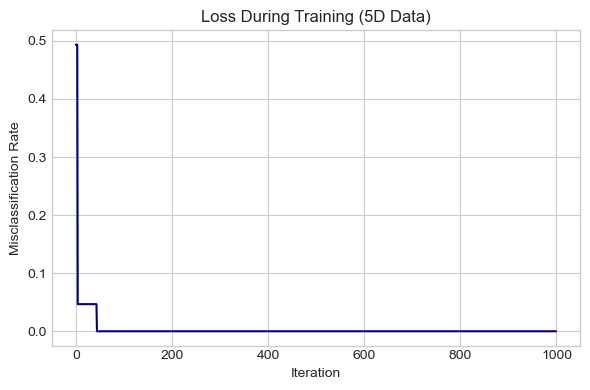

In [25]:
import torch
import matplotlib.pyplot as plt

# Generate higher-dimensional data (5D + bias)
def perceptron_data_highdim(n_points=300, noise=0.2, p_dims=5):
    y = torch.arange(n_points) >= int(n_points / 2)
    X = y[:, None] + torch.normal(0.0, noise, size=(n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), dim=1)  # Add bias column
    return X, y

# Generate data
X, y = perceptron_data_highdim(p_dims=5)
n = X.size(0)

# Initialize model and optimizer
torch.manual_seed(42)
p = Perceptron()
opt = PerceptronOptimizer(p)

# Train the model
max_iters = 1000
loss_vec = []

for _ in range(max_iters):
    loss = p.loss(X, y).item()
    loss_vec.append(loss)
    
    i = torch.randint(n, size=(1,))
    x_i = X[i[0]]
    y_i = y[i[0]]
    
    opt.step(x_i, y_i)

# Plot loss over time
plt.figure(figsize=(6, 4))
plt.plot(loss_vec, color='navy')
plt.xlabel("Iteration")
plt.ylabel("Misclassification Rate")
plt.title("Loss During Training (5D Data)")
plt.grid(True)
plt.tight_layout()
plt.show()


As we can see from the graph above, the loss consistently drops and eventually reaches zero and stays there. This suggests that the data is linearly separable in the 5D space, because we can eventually reach a loss of 0 which is perfect accuracy.

# Runtimes

> **Q:** What is the runtime complexity of a single iteration of the perceptron algorithm? Does the runtime complexity of a single iteration depend on the number of data points $n$? What about the number of features $p$? If you implemented minibatch perceptron, what is the runtime complexity of a single iteration of the minibatch perceptron algorithm?

A single iteration of of the perceptron algorithm involves the following steps:

1. Select one data point $(x_i,y_i)$, which takes constant time $O(1)$.
2. Compute the score $s = \langle \textbf{w},\textbf{x}_i \rangle$. This is a dot product of two length-$p$ vectors, so the run-time is $O(p)$.
3. Check if misclassified and, if so, compute and apply the update. Computing the update is $-y_i \cdot x_i$, which again has runtime $O(p)$. Updating the weights vector is vector addition and therefore has runtime $O(p)$.

Thus, the total complexity per iteration is $O(p)$.

This runtime does not depend on $n$ because only one data point is processed. However, both the dot product and weight vector update involve vectors of length $p$, so the runtime does depend on $p$. 

In minibatch perceptron, a batch of $b$ data points is processed together. So, for every $b$, the program do the same process outlined above that had a runtime of $O(p)$.

So the total runtime per iteration of minibatch perceptron is $O(b \cdot p)$

# Conclusion 

Through hands-on experimentation with the perceptron algorithm, I observed how effectively it learns a linear decision boundary when the data is linearly separable, converging to zero classification error over time. However, in cases where the data is not linearly separable, the perceptron fails to converge and continues to update the weights without settling, highlighting its limitations in more complex real-world scenarios. Extending the perceptron to higher dimensions confirmed that the algorithm can scale beyond 2D, with the loss curve providing insight into whether linear separation is likely. Overall, this project deepened my understanding of how simple learning algorithms operate and set the stage for exploring more advanced models like logistic regression or support vector machines.